In [1]:
import pandas as pd
#import stockstats as StockDataFrame
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from ipywidgets import *
from IPython.display import display

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
plt.rc("figure", figsize=(9, 7))
sns.set_style('whitegrid')

%matplotlib inline
pd.set_option('display.max_columns', 500)
from sklearn.metrics import f1_score
from scipy.optimize import least_squares
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime

/home/matthew/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Load stock data

In [2]:
df = pd.read_csv('toram.csv')

In [3]:
def middle_of_month(name):
    name['date'] = pd.DatetimeIndex(name['date'])
    stockmiddle = name.loc[:,('date','open')]
    stockmiddle['date'] = pd.DatetimeIndex(stockmiddle['date']) + pd.DateOffset(-14)
    stockmiddle['middle price'] = stockmiddle['open']
    stockmiddle.set_index('date', drop=False, inplace=True)
    stockmiddle.drop('open', 1, inplace=True)
    name.set_index('date', drop=False, inplace=True)
    output = pd.merge(name,stockmiddle, left_on='date', right_on='date')
    output['half month gain'] = (output['middle price'] / output['open']) - 1
    output.set_index('date', drop=False, inplace=True)
    return output

### Wendy's
low = middle_of_month('WEN')
lowquarterly = pd.read_csv('LOW_quarterly_financial_data.csv')
lowquarterly['Quarter end'] = pd.DatetimeIndex(lowquarterly['Quarter end']) + pd.DateOffset(3) 
wendy = pd.merge(lowquarterly,low, left_on='Quarter end', right_on='date')
print wendy.shape
print lowquarterly.shape
low.head()

In [4]:
chipotlestock = df[df['ticker'] == 'CMG']
chipotlestock['day'] = pd.DatetimeIndex(chipotlestock['date']).day
chipotlestock = middle_of_month(chipotlestock)

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [5]:
chipotlestock.head()

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,cr-ma1,cr-ma2,cr-ma3,volume_-3_s,volume_-1_s,volume_2_s,"volume_-3,2,-1_max",close_20_sma,close_20_mstd,boll,boll_ub,boll_lb,bollstatus,day,middle price,half month gain
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-01-26,2006-01-26,CMG,45.00,48.28,39.51,44.00,13218600.0,0.0,1.0,45.00,48.28,39.51,44.00,13218600.0,594837000.0,581618400.0,-13218600.0,0.199795,-1.00,-0.022222,105.573161,111.906160,-6.332998,-1.727165,-9.211665,11973469.0,-61.236971,42.20,2.80,43.930000,22.218117,95.681545,100.465021,82.717873,1476010.0,1245131.0,735800.0,1476010.0,113.4015,16.378348,113.4015,146.158197,80.644803,-0.544084,26,45.78,0.017333
2006-01-27,2006-01-27,CMG,44.88,44.90,41.75,42.20,1150800.0,0.0,1.0,44.88,44.90,41.75,42.20,1150800.0,51647904.0,48563760.0,-3084144.0,0.072706,-2.68,-0.059715,95.823444,106.742740,-10.919296,-3.565591,-14.707409,-12067800.0,-61.761949,45.50,-0.62,42.950000,22.067892,98.475745,99.191256,84.232425,2695251.0,13218600.0,1111200.0,13218600.0,109.5095,22.733451,109.5095,154.976402,64.042598,-0.210731,27,43.25,-0.036319
2006-01-30,2006-01-30,CMG,42.20,45.51,41.25,44.80,735800.0,0.0,1.0,42.20,45.51,41.25,44.80,735800.0,31050760.0,32963840.0,1913080.0,0.098202,2.60,0.061611,87.973684,102.154389,-14.180706,-5.688614,-16.984183,-415000.0,-6.222222,48.90,-6.70,43.853333,23.172441,101.277624,98.405242,85.585061,1245131.0,1150800.0,606700.0,1245131.0,105.9935,26.879833,105.9935,159.753166,52.233834,-0.093321,30,41.75,-0.010664
2006-01-31,2006-01-31,CMG,45.50,49.30,45.38,47.52,1111200.0,0.0,1.0,45.50,49.30,45.38,47.52,1111200.0,50559600.0,52804224.0,2244624.0,0.082805,2.02,0.044396,81.750040,98.107397,-16.357357,-7.822363,-17.069989,375400.0,1.381462,47.90,-2.40,47.400000,26.805558,85.885543,97.961458,87.275713,13218600.0,735800.0,401500.0,13218600.0,102.5570,29.740763,102.5570,162.038526,43.075474,0.020380,31,41.45,-0.089011
2006-02-01,2006-02-01,CMG,48.90,49.24,45.25,46.56,606700.0,0.0,1.0,48.90,49.24,45.25,46.56,606700.0,29667630.0,28247952.0,-1419678.0,0.084453,-2.34,-0.047853,76.336188,94.289072,-17.952884,-9.848467,-16.208834,-504500.0,15.876777,44.85,4.05,47.016667,27.138217,72.216371,98.900851,88.976484,1150800.0,1111200.0,245300.0,1150800.0,99.0530,32.034126,99.0530,163.121252,34.984748,0.108597,1,43.10,-0.118609


In [6]:
df.shape

(14010528, 44)

In [7]:
def derivative(data):
    data = data.iloc[1:]
    data['Category: All categories'] = data['Category: All categories'].astype(float)
    data['derivative'] = data['Category: All categories'].diff(periods = 1)
    data.index = [datetime.strptime(date, '%Y-%m').date() for date in data.index]
    return data
    
def stock(stock,datastock):
    stockdata = df[df['ticker'] == str(stock)]
    datastock = middle_of_month(stockdata)
    return datastock
    
def mergefunction(stock,derivative):
    stock = stock.iloc[1:]
    derivative = pd.merge(stock, derivative,
                          left_index = True,
                          right_index = True,
                          how='inner')
    return stock

In [8]:
chipotle = pd.read_csv('trendschipotle.csv')

In [9]:
mcdonalds = pd.read_csv('trendsmcdonalds.csv')

In [10]:
wendys = pd.read_csv('trendswendys.csv')

In [11]:
darden = pd.read_csv('darden_trends.csv')
darden = derivative(darden)
teststock = df[df['ticker'] == 'DRI']
dardenstock = middle_of_month(teststock)
#darden = darden.iloc[1:]
dardens = pd.merge(dardenstock, darden,
                    left_index = True,
                    right_index = True,
                    how='inner')
dardens.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,cr-ma1,cr-ma2,cr-ma3,volume_-3_s,volume_-1_s,volume_2_s,"volume_-3,2,-1_max",close_20_sma,close_20_mstd,boll,boll_ub,boll_lb,bollstatus,middle price,half month gain,Category: All categories,derivative
2004-03-01,2004-03-01,DRI,24.40,24.80,24.14,24.61,1464900.0,0.0,1.0,15.255276,15.505363,15.092720,15.386571,1464900.0,35743560.0,36051189.0,307629.0,0.026972,0.21,0.008607,22.842168,22.079587,0.762581,0.554890,0.415383,-2197600.0,0.826446,24.78,-0.38,24.516667,223.722149,166.280521,175.351485,136.286268,985000.0,3662500.0,1236200.0,3662500.0,22.3125,0.879723,22.3125,24.071947,20.553053,1.093226,24.75,0.014344,60.0,-2.0
2004-04-01,2004-04-01,DRI,24.30,24.55,23.84,24.09,2556300.0,0.0,1.0,15.192754,15.349058,14.905155,15.061459,2556300.0,62118090.0,61581267.0,-536823.0,0.029345,-0.21,-0.008642,24.554475,24.185193,0.369282,0.508697,-0.278831,1320500.0,-1.857835,24.00,0.30,24.160000,150.105798,159.035031,164.296631,213.427263,1008900.0,1235800.0,1485600.0,1485600.0,24.6360,0.353543,24.6360,25.343085,23.928915,0.262405,23.19,-0.045679,55.0,-5.0
2004-06-01,2004-06-01,DRI,22.27,22.61,22.04,22.37,589900.0,0.0,1.0,13.946849,14.159778,13.802809,14.009475,589900.0,13137073.0,13196063.0,58990.0,0.025532,0.10,0.004490,22.075744,22.314753,-0.239009,-0.369889,0.261761,-234000.0,0.997732,21.90,0.37,22.340000,74.257426,70.734269,63.715003,65.139918,1389400.0,823900.0,1028200.0,1389400.0,21.9990,0.313214,21.9990,22.625428,21.372572,0.716306,21.20,-0.048047,56.0,8.0
2004-07-01,2004-07-01,DRI,20.65,20.80,20.40,20.46,1001800.0,0.0,1.0,12.932305,13.026244,12.775740,12.813315,1001800.0,20687170.0,20496828.0,-190342.0,0.019417,-0.19,-0.009201,20.860444,21.273748,-0.413305,-0.355112,-0.116386,-452900.0,0.977995,20.36,0.29,20.553333,76.806468,90.718063,89.419766,78.822080,947700.0,1454700.0,704400.0,1454700.0,21.1700,0.481586,21.1700,22.133172,20.206828,0.230059,21.01,0.017433,50.0,-6.0
2004-09-01,2004-09-01,DRI,21.05,21.21,20.84,21.20,622600.0,0.0,1.0,13.182810,13.283012,13.051295,13.276749,622600.0,13105730.0,13199120.0,93390.0,0.017598,0.15,0.007126,20.799810,20.707337,0.092473,-0.062067,0.309079,19700.0,-1.080827,20.95,0.10,21.083333,82.878151,80.045051,72.397168,91.022795,598600.0,602900.0,514300.0,602900.0,20.3445,0.626816,20.3445,21.598132,19.090868,0.781382,21.10,0.002375,43.0,-13.0


In [12]:
dominos = pd.read_csv('dominos_trends.csv')
dominos = derivative(dominos)
teststock = df[df['ticker'] == 'DPZ']
dominostock = middle_of_month(teststock)
dominos = dominos.iloc[1:]
dominos = pd.merge(dominostock, dominos,
                    left_index = True,
                    right_index = True,
                    how='inner')
dominos.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,cr-ma1,cr-ma2,cr-ma3,volume_-3_s,volume_-1_s,volume_2_s,"volume_-3,2,-1_max",close_20_sma,close_20_mstd,boll,boll_ub,boll_lb,bollstatus,middle price,half month gain,Category: All categories,derivative
2004-09-01,2004-09-01,DPZ,14.25,14.59,14.25,14.45,421400.0,0.0,1.0,7.013343,7.180679,7.013343,7.111776,421400.0,6004950.0,6089230.0,84280.0,0.023578,0.20,0.014035,14.099256,18.360142,-4.260886,-6.107822,3.693872,19600.0,1.785714,14.05,0.20,14.430000,154.872280,86.060868,51.339218,17.243213,880600.0,401800.0,310100.0,880600.0,13.7650,0.278424,13.7650,14.321847,13.208153,0.935487,15.00,0.052632,20.0,0.0
2004-10-01,2004-10-01,DPZ,14.80,14.85,14.25,14.60,733500.0,0.0,1.0,7.288094,7.312716,7.017253,7.189607,733500.0,10855800.0,10709100.0,-146700.0,0.041237,-0.20,-0.013514,14.881615,15.552301,-0.670686,-1.012738,0.684104,-621000.0,-3.583062,14.90,-0.10,14.566667,116.115702,136.918243,131.698542,107.957736,223500.0,1354500.0,590600.0,1354500.0,14.7570,0.551658,14.7570,15.860315,13.653685,0.519487,15.89,0.073649,24.0,4.0
2004-11-01,2004-11-01,DPZ,16.45,16.99,16.16,16.80,288600.0,0.0,1.0,8.097226,8.363031,7.954478,8.269507,288600.0,4747470.0,4848480.0,101010.0,0.050075,0.35,0.021277,16.049954,15.895838,0.154117,0.039577,0.229079,-257100.0,2.941176,17.15,-0.70,16.650000,153.112314,116.764645,144.266814,141.553922,301800.0,545700.0,324100.0,545700.0,15.9340,0.295996,15.9340,16.525991,15.342009,0.935817,17.98,0.093009,22.0,-2.0
2004-12-01,2004-12-01,DPZ,17.94,18.33,17.94,18.22,281300.0,0.0,1.0,8.860873,9.053500,8.860873,8.999169,281300.0,5046522.0,5125286.0,78764.0,0.021505,0.28,0.015608,17.721973,17.273346,0.448627,0.430150,0.036955,-31500.0,-1.320132,18.45,-0.51,18.163333,198.057432,176.121562,171.877495,156.517857,47800.0,312800.0,115900.0,312800.0,17.4630,0.483332,17.4630,18.429665,16.496335,0.746725,18.23,0.016165,24.0,2.0
2005-02-01,2005-02-01,DPZ,16.61,16.83,16.50,16.50,207900.0,0.0,1.0,8.207113,8.315816,8.152761,8.152761,207900.0,3453219.0,3430350.0,-22869.0,0.019802,-0.11,-0.006623,16.958658,17.201230,-0.242572,-0.149154,-0.186838,-28900.0,-1.715976,16.77,-0.16,16.610000,88.009950,77.574458,77.027605,86.737323,159600.0,236800.0,193700.0,236800.0,17.2415,0.422289,17.2415,18.086078,16.396922,0.126145,17.00,0.023480,25.0,1.0


In [13]:
#Subsidiaries of Yum
pizzahut = pd.read_csv('pizzahut_trends.csv')
pizzahut = derivative(pizzahut)
kfc = pd.read_csv('kfc_trends.csv')
kfc = derivative(kfc)
tacobell = pd.read_csv('tacobell_trends.csv')
tacobell = derivative(tacobell)
wingstreet = pd.read_csv('wingstreet_trends.csv')
wingstreet = derivative(wingstreet)

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
racism = pd.read_csv('crackerbarrel_trends.csv')
racism = derivative(racism)
teststock = df[df['ticker'] == 'CBRL']
raciststock = middle_of_month(teststock)
racism = racism.iloc[1:]
racism = pd.merge(raciststock, racism,
                    left_index = True,
                    right_index = True,
                    how='inner')
racism.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,cr-ma1,cr-ma2,cr-ma3,volume_-3_s,volume_-1_s,volume_2_s,"volume_-3,2,-1_max",close_20_sma,close_20_mstd,boll,boll_ub,boll_lb,bollstatus,middle price,half month gain,Category: All categories,derivative
2004-03-01,2004-03-01,CBRL,37.93,38.80,37.93,38.53,475800.0,0.0,1.0,27.196381,27.820184,27.196381,27.626590,475800.0,18047094.0,18332574.0,285480.0,0.022677,0.60,0.015819,38.204063,38.278531,-0.074468,-0.041545,-0.065847,12200.0,1.092751,38.47,-0.54,38.420000,113.166969,96.953413,108.376429,90.611616,656200.0,463600.0,669700.0,669700.0,38.3300,0.699111,38.3300,39.728223,36.931777,0.356961,39.12,0.031374,30.0,1.0
2004-04-01,2004-04-01,CBRL,39.51,40.01,39.51,40.00,634500.0,0.0,1.0,28.329265,28.687773,28.329265,28.680603,634500.0,25069095.0,25380000.0,310905.0,0.012575,0.49,0.012402,38.920281,38.671641,0.248640,0.055652,0.385975,-49100.0,1.281723,40.20,-0.69,39.840000,145.113663,87.915767,93.681306,109.217056,382700.0,683600.0,276900.0,683600.0,38.7080,0.745050,38.7080,40.198100,37.217900,0.769109,39.68,0.004303,32.0,2.0
2004-06-01,2004-06-01,CBRL,32.18,33.03,32.18,32.73,892400.0,0.0,1.0,23.137654,23.748810,23.137654,23.533108,892400.0,28717432.0,29208252.0,490820.0,0.026070,0.55,0.017091,32.839283,34.413032,-1.573750,-1.568632,-0.010236,123400.0,1.546229,32.35,-0.17,32.646667,48.710765,33.712288,38.017541,72.694975,926200.0,769000.0,598800.0,926200.0,33.9450,2.045419,33.9450,38.035839,29.854161,0.284274,32.28,0.003108,34.0,0.0
2004-07-01,2004-07-01,CBRL,30.66,31.32,30.66,31.23,741400.0,0.0,1.0,22.044763,22.519308,22.044763,22.454597,741400.0,22731324.0,23153922.0,422598.0,0.021297,0.57,0.018591,31.495608,32.231896,-0.736288,-0.774836,0.077095,-400600.0,-1.032924,31.23,-0.57,31.070000,96.508814,72.393413,67.713183,51.223346,715400.0,1142000.0,544600.0,1142000.0,31.8955,0.611481,31.8955,33.118462,30.672538,-0.005126,32.56,0.061970,34.0,0.0
2004-09-01,2004-09-01,CBRL,31.84,32.76,31.84,32.33,459000.0,0.0,1.0,22.972258,23.636029,22.972258,23.325788,459000.0,14614560.0,14839470.0,224910.0,0.028483,0.49,0.015389,31.853127,31.839728,0.013399,-0.106264,0.239327,-32200.0,-0.655226,32.78,-0.94,32.310000,98.623668,98.530014,97.388664,118.270675,205200.0,491200.0,191400.0,491200.0,31.5170,0.646244,31.5170,32.809488,30.224512,0.624953,35.25,0.107098,29.0,-4.0


In [15]:
texas = pd.read_csv('texasroadhouse_trends.csv')
texas = derivative(texas)
teststock = df[df['ticker'] == 'TXRH']
texasstock = middle_of_month(teststock)
texas = texas.iloc[1:]
texas = pd.merge(texasstock, texas,
                    left_index = True,
                    right_index = True,
                    how='inner')
texas.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,cr-ma1,cr-ma2,cr-ma3,volume_-3_s,volume_-1_s,volume_2_s,"volume_-3,2,-1_max",close_20_sma,close_20_mstd,boll,boll_ub,boll_lb,bollstatus,middle price,half month gain,Category: All categories,derivative
2004-11-01,2004-11-01,TXRH,22.60,23.40,22.600,23.05,152000.0,0.0,1.0,9.915473,10.266463,9.915473,10.112905,304000.0,3435200.0,3503600.0,68400.0,0.034783,0.45,0.019912,25.406170,35.643880,-10.237710,-11.929363,3.383307,-62500.0,-1.396161,24.50,-1.90,23.016667,23.102689,23.695938,23.014146,58.737814,153500.0,214500.0,116000.0,214500.0,23.54045,0.776861,23.54045,25.094172,21.986728,0.197356,26.150,0.157080,16.0,0.0
2004-12-01,2004-12-01,TXRH,25.80,26.25,25.121,26.07,194900.0,0.0,1.0,11.319433,11.516865,11.021531,11.437893,389800.0,5028420.0,5081043.0,52623.0,0.043955,0.27,0.010465,25.182173,27.073205,-1.891032,-2.973909,2.165753,69200.0,7.544810,27.15,-1.35,25.813667,121.454404,102.689235,109.580399,52.042126,5800.0,125700.0,199800.0,199800.0,24.74960,0.768786,24.74960,26.287171,23.212029,0.841578,27.350,0.060078,22.0,6.0
2005-02-01,2005-02-01,TXRH,32.25,32.41,31.660,31.87,110500.0,0.0,1.0,14.149292,14.219490,13.890437,13.982571,221000.0,3563625.0,3521635.0,-41990.0,0.023412,-0.38,-0.011783,30.713104,29.977993,0.735111,0.597163,0.275896,-69600.0,5.737705,31.99,0.26,31.980000,141.811121,116.647815,110.687566,123.378352,34900.0,180100.0,77900.0,180100.0,30.26920,0.904220,30.26920,32.077640,28.460760,1.047654,29.380,-0.088992,19.0,-2.0
2005-03-01,2005-03-01,TXRH,27.65,28.93,27.650,28.60,168000.0,0.0,1.0,12.131098,12.692683,12.131098,12.547899,336000.0,4645200.0,4804800.0,159600.0,0.045246,0.95,0.034358,28.254133,28.977668,-0.723535,-0.545196,-0.356679,17700.0,2.788104,28.09,-0.44,28.393333,78.334908,58.821878,89.158490,119.306336,60100.0,150300.0,116500.0,150300.0,29.49070,2.108934,29.49070,33.708568,25.272832,0.281797,28.900,0.045208,20.0,1.0
2005-04-01,2005-04-01,TXRH,28.36,28.36,26.800,27.07,207100.0,0.0,1.0,12.442602,12.442602,11.758171,11.876630,414200.0,5873356.0,5606197.0,-267159.0,0.056563,-1.29,-0.045487,28.652670,28.842369,-0.189699,-0.003564,-0.372270,131900.0,0.567376,27.76,0.60,27.410000,113.435244,97.900160,70.024560,63.673525,226000.0,75200.0,83600.0,226000.0,28.87450,0.909270,28.87450,30.693040,27.055960,0.358540,28.325,-0.001234,20.0,0.0


In [16]:
jack = pd.read_csv('jackinthebox_trends.csv')
jack = derivative(jack)
teststock = df[df['ticker'] == 'JACK']
jackstock = middle_of_month(teststock)
jack = jack.iloc[1:]
jack = pd.merge(jackstock, jack,
                    left_index = True,
                    right_index = True,
                    how='inner')
jack.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,cr-ma1,cr-ma2,cr-ma3,volume_-3_s,volume_-1_s,volume_2_s,"volume_-3,2,-1_max",close_20_sma,close_20_mstd,boll,boll_ub,boll_lb,bollstatus,middle price,half month gain,Category: All categories,derivative
2004-03-01,2004-03-01,JACK,24.97,25.08,24.88,24.93,275200.0,0.0,1.0,11.971432,12.024170,11.928283,11.952255,550400.0,6871744.0,6860736.0,-11008.0,0.008006,-0.04,-0.001602,24.947632,24.430627,0.517005,0.602586,-0.171162,-207200.0,-0.359138,24.98,-0.01,24.963333,123.390663,163.225888,154.478597,147.430898,553000.0,482400.0,297100.0,553000.0,24.6480,0.738515,24.6480,26.125031,23.170969,0.609002,24.55,-0.016820,49.0,11.0
2004-04-01,2004-04-01,JACK,27.86,28.87,26.85,28.83,2894100.0,0.0,1.0,13.356993,13.841219,12.872766,13.822042,5788200.0,80629626.0,83436903.0,2807277.0,0.072505,0.97,0.034817,25.185051,24.765676,0.419375,0.078168,0.682414,2650800.0,12.976480,28.88,-1.02,28.183333,157.050324,85.589091,97.974798,122.361603,423100.0,243300.0,553500.0,553500.0,24.5985,1.107825,24.5985,26.814149,22.382851,1.236015,27.04,-0.029433,44.0,-5.0
2004-06-01,2004-06-01,JACK,27.97,28.35,27.89,28.27,261300.0,0.0,1.0,13.409730,13.591915,13.371376,13.553560,522600.0,7308561.0,7386951.0,78390.0,0.016358,0.30,0.010726,27.562868,27.245396,0.317472,0.168451,0.298044,17000.0,-0.071454,28.18,-0.21,28.170000,105.041747,102.431674,84.378793,113.877784,202500.0,244300.0,333500.0,333500.0,27.1185,0.683337,27.1185,28.485173,25.751827,0.811523,29.30,0.047551,44.0,-2.0
2004-07-01,2004-07-01,JACK,29.57,29.70,29.25,29.65,169300.0,0.0,1.0,14.176822,14.239149,14.023404,14.215177,338600.0,5006201.0,5019745.0,13544.0,0.015267,0.08,0.002705,29.629364,29.150640,0.478724,0.576271,-0.195095,-120600.0,0.373388,29.57,0.00,29.533333,161.167513,208.355309,186.355077,135.904745,318200.0,289900.0,192700.0,318200.0,29.5535,0.411750,29.5535,30.377001,28.729999,0.510018,30.15,0.019614,40.0,-4.0
2004-09-01,2004-09-01,JACK,28.17,29.00,28.17,28.56,273000.0,0.0,1.0,13.505617,13.903546,13.505617,13.692595,546000.0,7690410.0,7796880.0,106470.0,0.029036,0.39,0.013845,28.537902,28.784275,-0.246373,-0.340355,0.187964,42500.0,-2.559668,28.87,-0.70,28.576667,58.502080,67.062222,63.957575,91.936489,176500.0,230500.0,118300.0,230500.0,28.2105,0.552090,28.2105,29.314681,27.106319,0.481661,28.93,0.026979,48.0,5.0


In [17]:
daveandbusters = pd.read_csv('daveandbusters_trends.csv')
daveandbusters = derivative(daveandbusters)
teststock = df[df['ticker'] == 'PLAY']
davestock = middle_of_month(teststock)
dave = daveandbusters.iloc[1:]
dave = pd.merge(davestock, dave,
                    left_index = True,
                    right_index = True,
                    how='inner')
dave.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,cr-ma1,cr-ma2,cr-ma3,volume_-3_s,volume_-1_s,volume_2_s,"volume_-3,2,-1_max",close_20_sma,close_20_mstd,boll,boll_ub,boll_lb,bollstatus,date,middle price,half month gain,Category: All categories,derivative


In [18]:
gobble = pd.read_csv('cheesecakefactory_trends.csv')
gobble = derivative(gobble)
teststock = df[df['ticker'] == 'CAKE']
gobblestock = middle_of_month(teststock)
gobble = gobble.iloc[1:]
gobble = pd.merge(gobblestock, gobble,
                    left_index = True,
                    right_index = True,
                    how='inner')
gobble.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,cr-ma1,cr-ma2,cr-ma3,volume_-3_s,volume_-1_s,volume_2_s,"volume_-3,2,-1_max",close_20_sma,close_20_mstd,boll,boll_ub,boll_lb,bollstatus,middle price,half month gain,Category: All categories,derivative
2004-03-01,2004-03-01,CAKE,47.135,48.71,47.13,48.41,844200.0,0.0,1.0,29.224993,30.201536,29.221893,30.015528,1266300.0,39791367.00,40867722.0,1076355.00,0.032972,1.275,0.027050,45.939896,44.958378,0.981518,0.746811,0.469413,201333.0,3.547891,48.63,-1.495,48.083333,193.121739,147.480579,138.559896,113.698889,265400.0,642867.0,502200.0,642867.0,45.2285,1.167450,45.2285,47.563399,42.893601,0.908262,47.89,0.016018,54.0,-13.0
2004-04-01,2004-04-01,CAKE,46.330,46.63,45.64,45.92,480600.0,0.0,1.0,28.725871,28.911879,28.298052,28.471660,720900.0,22266198.00,22069152.0,-197046.00,0.021459,-0.410,-0.008850,45.765379,45.874611,-0.109231,-0.062326,-0.093811,127133.0,0.936819,45.93,0.400,46.063333,117.128221,98.431127,120.996807,171.747470,683400.0,353467.0,450600.0,683400.0,46.3140,1.581339,46.3140,49.476679,43.151321,0.502530,46.32,-0.000216,55.0,1.0
2004-06-01,2004-06-01,CAKE,38.700,39.58,38.65,39.26,542600.0,0.0,1.0,23.995062,24.540686,23.964060,24.342277,813900.0,20998620.00,21302476.0,303856.00,0.023776,0.560,0.014470,39.476131,40.836427,-1.360297,-1.417984,0.115374,-301867.0,-1.501654,38.35,0.350,39.163333,60.614988,48.591415,53.939239,76.494131,612400.0,844467.0,1246000.0,1246000.0,40.4610,1.901564,40.4610,44.264128,36.657872,0.268480,40.89,0.056589,57.0,4.0
2004-07-01,2004-07-01,CAKE,39.660,39.96,39.22,39.24,523600.0,0.0,1.0,24.590288,24.776296,24.317476,24.329876,785400.0,20765976.00,20546064.0,-219912.00,0.018692,-0.420,-0.010590,40.264429,40.527376,-0.262947,-0.161935,-0.202024,-436467.0,-1.343284,38.82,0.840,39.473333,115.850008,114.270211,95.200947,69.935216,379067.0,960067.0,708667.0,960067.0,40.5835,0.674538,40.5835,41.932576,39.234424,0.157729,39.98,0.008069,62.0,5.0
2004-09-01,2004-09-01,CAKE,41.460,42.00,41.14,42.00,388467.0,0.0,1.0,25.706337,26.041152,25.507929,26.041152,582700.5,16105841.82,16315614.0,209772.18,0.020688,0.540,0.013025,40.717115,40.420272,0.296843,0.035162,0.523363,8000.0,1.468429,41.74,-0.280,41.713333,94.291987,95.171536,98.513247,108.483845,325000.0,380467.0,280000.0,380467.0,39.8900,1.035857,39.8900,41.961713,37.818287,0.878913,41.32,-0.003377,56.0,-6.0


In [19]:
buffalo8 = pd.read_csv('buffalowildwings_trends.csv')
buffalo8 = derivative(buffalo8)
teststock = df[df['ticker'] == 'BWLD']
buffalo8stock = middle_of_month(teststock)
buffalo8 = buffalo8.iloc[1:]
buffalo8 = pd.merge(buffalo8stock, buffalo8,
                    left_index = True,
                    right_index = True,
                    how='inner')
buffalo8.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,cr-ma1,cr-ma2,cr-ma3,volume_-3_s,volume_-1_s,volume_2_s,"volume_-3,2,-1_max",close_20_sma,close_20_mstd,boll,boll_ub,boll_lb,bollstatus,middle price,half month gain,Category: All categories,derivative
2004-03-01,2004-03-01,BWLD,25.25,25.30,24.90,24.96,95700.0,0.0,1.0,12.625,12.650,12.450,12.480,191400.0,2416425.0,2388672.0,-27753.0,0.015936,-0.29,-0.011485,24.795768,24.733556,0.062213,0.087891,-0.051357,46600.0,4.346173,24.9,0.35,25.053333,141.648185,109.231364,108.190156,125.545924,47500.0,49100.0,102800.0,102800.0,24.858330,0.398080,24.858330,25.654490,24.062170,0.745974,27.22,0.078020,12.0,0.0
2004-04-01,2004-04-01,BWLD,28.55,29.45,28.11,28.25,46200.0,0.0,1.0,14.275,14.725,14.055,14.125,92400.0,1319010.0,1305150.0,-13860.0,0.046560,-0.30,-0.010508,27.629718,26.808294,0.821424,0.708104,0.226641,200.0,2.697842,29.1,-0.55,28.603333,190.648140,149.021299,148.028512,126.784840,60600.0,46000.0,69900.0,69900.0,27.071500,0.889306,27.071500,28.850112,25.292888,0.915633,27.60,-0.033275,11.0,-1.0
2004-06-01,2004-06-01,BWLD,30.03,30.22,29.69,29.69,56500.0,0.0,1.0,15.015,15.110,14.845,14.845,113000.0,1696695.0,1677485.0,-19210.0,0.017693,-0.34,-0.011322,30.047582,30.155561,-0.107980,0.087167,-0.390294,-63000.0,-2.022838,29.5,0.53,29.866667,92.836023,116.761922,118.508495,151.757911,161200.0,119500.0,50100.0,161200.0,30.627500,1.356706,30.627500,33.340911,27.914089,0.389899,27.60,-0.080919,11.0,1.0
2004-07-01,2004-07-01,BWLD,28.33,28.34,27.52,27.84,82900.0,0.0,1.0,14.165,14.170,13.760,13.920,165800.0,2348557.0,2307936.0,-40621.0,0.029359,-0.49,-0.017296,27.672320,28.143918,-0.471597,-0.631123,0.319051,25400.0,0.818505,28.0,0.33,27.900000,79.496486,66.037048,58.290223,86.292936,95600.0,57500.0,89400.0,95600.0,27.743945,0.954183,27.743945,29.652311,25.835579,0.653549,30.64,0.081539,11.0,0.0
2004-09-01,2004-09-01,BWLD,27.70,28.87,27.70,28.55,102200.0,0.0,1.0,13.850,14.435,13.850,14.275,204400.0,2830940.0,2917810.0,86870.0,0.041365,0.85,0.030686,28.374116,28.482369,-0.108253,-0.159103,0.101699,-57500.0,-3.652174,28.0,-0.30,28.373333,103.250419,73.787220,72.547535,98.133281,21900.0,159700.0,65900.0,159700.0,28.207500,0.439578,28.207500,29.086656,27.328344,0.211371,27.20,-0.018051,14.0,0.0


In [20]:
#Bloomin' Brands
bonefish = pd.read_csv('bonefish_trends.csv')
bonefish = derivative(bonefish)
carrabba = pd.read_csv('carrabba_trends.csv')
carrabba = derivative(carrabba)
flemings = pd.read_csv('flemings_trends.csv')
flemings = derivative(flemings)
outback = pd.read_csv('outbacksteakhouse_trends.csv')
outback = derivative(outback)

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [21]:
walmart = pd.read_csv('walmart_trends.csv')
walmart = derivative(walmart)
teststock = df[df['ticker'] == 'WMT']
walmartstock = middle_of_month(teststock)
walmart = walmart.iloc[1:]
walmart = pd.merge(walmartstock, walmart,
                    left_index = True,
                    right_index = True,
                    how='inner')
walmart.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,cr-ma1,cr-ma2,cr-ma3,volume_-3_s,volume_-1_s,volume_2_s,"volume_-3,2,-1_max",close_20_sma,close_20_mstd,boll,boll_ub,boll_lb,bollstatus,date,middle price,half month gain,Category: All categories,derivative


In [22]:
costco = pd.read_csv('costco_trends.csv')
costco = derivative(costco)
teststock = df[df['ticker'] == 'COST']
costcostock = middle_of_month(teststock)
costco = costco.iloc[1:]
costco = pd.merge(costcostock, costco,
                    left_index = True,
                    right_index = True,
                    how='inner')
costco.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,cr-ma1,cr-ma2,cr-ma3,volume_-3_s,volume_-1_s,volume_2_s,"volume_-3,2,-1_max",close_20_sma,close_20_mstd,boll,boll_ub,boll_lb,bollstatus,middle price,half month gain,Category: All categories,derivative
2004-03-01,2004-03-01,COST,39.18,40.00,38.95,39.94,4552100.0,0.0,1.0,30.563133,31.202790,30.383717,31.155986,4552100.0,178351278.0,181810874.0,3459596.0,0.026599,0.76,0.019398,38.533792,38.022732,0.511059,0.397723,0.226673,-1566600.0,1.660612,38.72,0.46,39.630000,169.018135,123.978444,121.569182,117.520088,2755000.0,6118700.0,10196700.0,10196700.0,38.1940,0.750567,38.1940,39.695133,36.692867,0.828419,38.13,-0.026799,31.0,-1.0
2004-04-01,2004-04-01,COST,37.43,37.63,36.89,37.35,2509800.0,0.0,1.0,29.198011,29.354025,28.776773,29.135605,2509800.0,93941814.0,93741030.0,-200784.0,0.019860,-0.08,-0.002137,37.223286,37.416500,-0.193214,-0.230864,0.075300,-170200.0,0.916689,37.62,-0.19,37.290000,80.903307,86.868711,89.736442,121.947702,1664800.0,2680000.0,2203500.0,2680000.0,37.2950,0.498897,37.2950,38.292795,36.297205,0.567649,37.85,0.011221,33.0,2.0
2004-06-01,2004-06-01,COST,37.72,38.21,37.65,38.14,2723900.0,0.0,1.0,29.505290,29.888577,29.450534,29.833821,2723900.0,102745508.0,103889546.0,1144038.0,0.014764,0.42,0.011135,37.281744,37.152959,0.128785,-0.115839,0.489247,41300.0,-2.025974,39.25,-1.53,38.000000,98.737601,90.714356,83.861854,102.004527,1675700.0,2682600.0,5426500.0,5426500.0,36.7615,0.784032,36.7615,38.329565,35.193435,0.805631,41.25,0.093584,39.0,2.0
2004-07-01,2004-07-01,COST,41.25,41.40,40.71,40.87,4025800.0,0.0,1.0,32.266522,32.383854,31.844123,31.969278,4025800.0,166064250.0,164534446.0,-1529804.0,0.016807,-0.38,-0.009212,41.355508,40.526084,0.829425,1.045901,-0.432953,-396000.0,-1.126558,40.42,0.83,40.993333,148.787062,214.740857,196.391981,127.670477,3151000.0,4421800.0,3579200.0,4421800.0,41.1880,1.067474,41.1880,43.322947,39.053053,0.514520,40.88,-0.008970,42.0,3.0
2004-09-01,2004-09-01,COST,41.11,41.33,40.46,40.83,4785300.0,0.0,1.0,32.235157,32.407663,31.725479,32.015603,4785300.0,196723683.0,195383799.0,-1339884.0,0.021274,-0.28,-0.006811,41.548894,41.350449,0.198445,0.273991,-0.151093,656000.0,-1.838586,40.26,0.85,40.873333,101.142681,117.507281,112.604361,96.802707,2231600.0,4129300.0,3536900.0,4129300.0,41.2925,0.807868,41.2925,42.908235,39.676765,0.443524,41.16,0.001216,37.0,-5.0


In [23]:
target = pd.read_csv('target_trends.csv')
target = derivative(target)
teststock = df[df['ticker'] == 'TGT']
targetstock = middle_of_month(teststock)
target = target.iloc[1:]
target = pd.merge(targetstock, target,
                    left_index = True,
                    right_index = True,
                    how='inner')
target.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,cr-ma1,cr-ma2,cr-ma3,volume_-3_s,volume_-1_s,volume_2_s,"volume_-3,2,-1_max",close_20_sma,close_20_mstd,boll,boll_ub,boll_lb,bollstatus,middle price,half month gain,Category: All categories,derivative
2004-03-01,2004-03-01,TGT,44.16,44.59,44.16,44.41,4221400.0,0.0,1.0,34.249149,34.582644,34.249149,34.443042,4221400.0,186417024.0,187472374.0,1055350.0,0.009690,0.25,0.005661,42.635314,41.326101,1.309213,1.079796,0.458835,-1449400.0,2.889096,43.35,0.81,44.386667,248.164930,190.401715,169.411638,118.616738,2618800.0,5670800.0,3662400.0,5670800.0,41.4570,1.777793,41.4570,45.012586,37.901414,0.880106,45.51,0.030571,34.0,4.0
2004-04-01,2004-04-01,TGT,44.40,44.60,43.81,44.32,4986000.0,0.0,1.0,34.435286,34.590400,33.977700,34.373240,4986000.0,221378400.0,220979520.0,-398880.0,0.017871,-0.08,-0.001802,44.584217,43.938179,0.646037,0.769614,-0.247153,1745100.0,-1.333333,44.62,-0.22,44.243333,116.520817,133.874548,161.496329,198.084905,3537500.0,3240900.0,2577000.0,3537500.0,44.3455,1.014139,44.3455,46.373778,42.317222,0.513435,43.05,-0.030405,34.0,0.0
2004-06-01,2004-06-01,TGT,44.55,44.90,43.88,44.26,2413000.0,0.0,1.0,34.607401,34.879289,34.086931,34.382123,2413000.0,107499150.0,106799380.0,-699770.0,0.022978,-0.29,-0.006510,43.908586,43.845232,0.063354,-0.080527,0.287763,78400.0,1.250000,45.00,-0.45,44.346667,102.835588,100.573430,89.142271,91.680518,3420900.0,2334600.0,4280600.0,4280600.0,43.7290,0.662267,43.7290,45.053534,42.404466,0.809920,45.90,0.030303,36.0,1.0
2004-07-01,2004-07-01,TGT,42.80,43.24,41.94,42.25,5166100.0,0.0,1.0,33.247963,33.589765,32.579897,32.820712,5166100.0,221109080.0,218267725.0,-2841355.0,0.030524,-0.55,-0.012850,44.102025,44.518582,-0.416557,0.069561,-0.972236,-162300.0,0.116959,41.20,1.60,42.476667,97.286550,145.698902,146.309319,122.085199,5027800.0,5328400.0,4656400.0,5328400.0,45.1265,1.336284,45.1265,47.799067,42.453933,0.064744,43.00,0.004673,40.0,4.0
2004-09-01,2004-09-01,TGT,44.53,44.97,44.43,44.96,2522200.0,0.0,1.0,34.654602,34.997024,34.576779,34.989241,2522200.0,112313566.0,113398112.0,1084546.0,0.012081,0.43,0.009656,44.283829,43.777564,0.506265,0.332051,0.348427,-2400200.0,-0.824053,45.77,-1.24,44.786667,111.465852,118.529706,120.833341,98.984754,2087800.0,4922400.0,2531200.0,4922400.0,43.3220,1.546638,43.3220,46.415276,40.228724,0.695262,46.05,0.034134,36.0,-6.0


In [24]:
dollargeneral = pd.read_csv('dollargeneral_trends.csv')
dollargeneral = derivative(dollargeneral)
teststock = df[df['ticker'] == 'DG']
dollargeneralstock = middle_of_month(teststock)
dollargeneral = dollargeneral[1:]
dollargeneral = pd.merge(dollargeneralstock, dollargeneral,
                    left_index = True,
                    right_index = True,
                    how='inner')
dollargeneral.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,cr-ma1,cr-ma2,cr-ma3,volume_-3_s,volume_-1_s,volume_2_s,"volume_-3,2,-1_max",close_20_sma,close_20_mstd,boll,boll_ub,boll_lb,bollstatus,middle price,half month gain,Category: All categories,derivative
2009-12-01,2009-12-01,DG,23.44,23.57,23.00,23.31,803500.0,0.0,1.0,22.787338,22.913719,22.359590,22.660958,803500.0,18834040.0,18729585.0,-104455.0,0.024479,-0.13,-0.005546,22.642954,21.505482,1.137471,1.026565,0.221812,-49500.0,3.078276,23.82,-0.38,23.293333,213.610889,292.397838,257.490537,134.041970,362600.0,853000.0,410000.0,853000.0,21.4745,2.099678,21.4745,25.673855,17.275145,0.734024,22.80,-0.027304,18.0,1.0
2010-03-01,2010-03-01,DG,24.01,24.57,23.88,24.09,271500.0,0.0,1.0,23.341467,23.885875,23.215087,23.419240,271500.0,6518715.0,6540435.0,21720.0,0.028483,0.08,0.003332,23.528917,23.338814,0.190103,0.038602,0.303002,6500.0,0.797649,24.00,0.01,24.180000,96.299739,90.061918,85.477713,109.058317,208400.0,265000.0,114700.0,265000.0,23.1050,0.740721,23.1050,24.586441,21.623559,0.805446,25.16,0.047897,15.0,1.0
2010-04-01,2010-04-01,DG,25.35,25.80,25.29,25.52,1232200.0,0.0,1.0,24.644156,25.081627,24.585827,24.809423,1232200.0,31236270.0,31445744.0,209474.0,0.019965,0.17,0.006706,25.222172,24.849461,0.372712,0.403176,-0.060929,20100.0,-0.588235,26.11,-0.76,25.536667,137.442596,156.923132,176.899348,128.819050,336700.0,1212100.0,716600.0,1212100.0,25.1595,0.361464,25.1595,25.882428,24.436572,0.631756,27.50,0.084813,15.0,0.0
2010-06-01,2010-06-01,DG,30.23,30.98,30.08,30.54,667200.0,0.0,1.0,29.388278,30.117395,29.242455,29.689646,667200.0,20169456.0,20376288.0,206832.0,0.029479,0.31,0.010255,29.932987,29.228810,0.704177,0.651280,0.105793,-301500.0,-2.703573,31.06,-0.83,30.533333,115.813769,123.466237,134.604365,151.123133,4955600.0,968700.0,773600.0,4955600.0,29.2760,1.018659,29.2760,31.313318,27.238682,0.734131,30.19,-0.001323,16.0,1.0
2010-07-01,2010-07-01,DG,27.51,28.16,27.37,28.13,1658000.0,0.0,1.0,26.744013,27.375915,26.607912,27.346750,1658000.0,45611580.0,46639540.0,1027960.0,0.028453,0.62,0.022537,28.880708,29.218479,-0.337771,-0.077645,-0.520251,21200.0,-3.099683,28.16,-0.65,27.886667,77.938843,99.775112,124.267916,126.825808,310500.0,1636800.0,560000.0,1636800.0,29.4230,0.765919,29.4230,30.954837,27.891163,-0.124414,28.29,0.028353,17.0,1.0


In [25]:
dollartree = pd.read_csv('dollartree_trends.csv')
dollartree = derivative(dollartree)
teststock = df[df['ticker'] == 'DLTR']
dollartreestock = middle_of_month(teststock)
dollartree = dollartree.iloc[1:]
dollartree = pd.merge(dollartreestock, dollartree,
                    left_index = True,
                    right_index = True,
                    how='inner')
dollartree.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,cr-ma1,cr-ma2,cr-ma3,volume_-3_s,volume_-1_s,volume_2_s,"volume_-3,2,-1_max",close_20_sma,close_20_mstd,boll,boll_ub,boll_lb,bollstatus,middle price,half month gain,Category: All categories,derivative
2004-03-01,2004-03-01,DLTR,30.9500,31.75,30.75,31.58,2028000.0,0.0,1.0,10.316667,10.583333,10.250000,10.526667,6084000.0,6.276660e+07,64044240.00,1.277640e+06,0.032000,0.6300,0.020355,31.977486,32.182640,-0.205154,0.061250,-0.532807,-268067.0,-0.705807,31.36,-0.4100,31.360000,99.787554,111.657757,129.366471,135.718151,6994467.0,2296067.0,1270000.0,6994467.0,32.58550,0.849386,32.58550,34.284272,30.886728,0.018623,29.50,-0.046850,5.0,0.0
2004-04-01,2004-04-01,DLTR,30.0445,30.69,29.89,30.11,2702467.0,0.0,1.0,10.014833,10.230000,9.963333,10.036667,8107401.0,8.119427e+07,81371281.37,1.770116e+05,0.026411,0.0655,0.002180,29.916369,30.197104,-0.280735,-0.551564,0.541659,1041800.0,-0.382958,30.91,-0.8655,30.230000,91.366745,62.423018,57.733436,85.398156,905467.0,1660667.0,1199400.0,1660667.0,29.69100,0.991606,29.69100,31.674211,27.707789,0.589123,29.00,-0.034765,6.0,1.0
2004-06-01,2004-06-01,DLTR,27.7600,28.62,27.76,28.34,1916200.0,0.0,1.0,9.253333,9.540000,9.253333,9.446667,5748600.0,5.319371e+07,54305108.00,1.111396e+06,0.030507,0.5800,0.020893,26.482687,26.715199,-0.232512,-0.730980,0.996936,-926267.0,2.246777,28.38,-0.6200,28.240000,91.668878,57.064382,53.738586,74.174225,1224800.0,2842467.0,847400.0,2842467.0,25.96150,1.325138,25.96150,28.611776,23.311224,0.839304,27.58,-0.006484,7.0,0.0
2004-07-01,2004-07-01,DLTR,27.4490,27.45,26.78,26.79,968400.0,0.0,1.0,9.149667,9.150000,8.926667,8.930000,2905200.0,2.658161e+07,25943436.00,-6.381756e+05,0.024710,-0.6590,-0.024008,27.727101,27.691647,0.035455,0.185878,-0.300847,-686200.0,-2.524858,26.47,0.9790,27.006667,125.634560,163.653908,142.217415,103.138157,1163067.0,1654600.0,1115467.0,1654600.0,28.07475,0.569550,28.07475,29.213849,26.935651,0.225331,27.30,-0.005428,7.0,0.0
2004-09-01,2004-09-01,DLTR,23.6700,23.96,23.32,23.62,732067.0,0.0,1.0,7.890000,7.986667,7.773333,7.873333,2196201.0,1.732803e+07,17291422.54,-3.660335e+04,0.027073,-0.0500,-0.002112,24.046354,24.608031,-0.561677,-0.607171,0.090988,-114733.0,-1.292744,24.90,-1.2300,23.633333,68.241229,74.207324,66.019278,70.207265,1453600.0,846800.0,1660867.0,1660867.0,23.95050,0.627630,23.95050,25.205760,22.695240,0.388270,26.95,0.138572,7.0,-1.0


In [26]:
burlington = pd.read_csv('burlington_trends.csv')
burlington = derivative(burlington)
teststock = df[df['ticker'] == 'BURL']
burlingtonstock = middle_of_month(teststock)
burlington = burlington.iloc[1:]
burlington = pd.merge(burlingtonstock, burlington,
                    left_index = True,
                    right_index = True,
                    how='inner')
burlington.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,cr-ma1,cr-ma2,cr-ma3,volume_-3_s,volume_-1_s,volume_2_s,"volume_-3,2,-1_max",close_20_sma,close_20_mstd,boll,boll_ub,boll_lb,bollstatus,middle price,half month gain,Category: All categories,derivative
2013-11-01,2013-11-01,BURL,26.93,27.26,26.54,27.16,82600.0,0.0,1.0,26.93,27.26,26.54,27.16,82600.0,2224418.0,2243416.0,18998.0,0.026766,0.23,0.008541,26.177790,22.586171,3.591618,4.364578,-1.545919,2700.0,1.622642,27.53,-0.60,26.986667,329.872765,348.945190,433.558461,576.551109,94500.0,79900.0,175300.0,175300.0,26.594,0.582926,26.594,27.759852,25.428148,0.644101,30.32,0.125882,76.0,19.0
2014-04-01,2014-04-01,BURL,29.48,30.14,29.48,30.00,180400.0,0.0,1.0,29.48,30.14,29.48,30.00,180400.0,5318192.0,5412000.0,93808.0,0.022140,0.52,0.017639,29.131721,28.233409,0.898312,0.713472,0.369680,-70300.0,-1.503508,30.56,-1.08,29.873333,150.370005,151.297658,137.712687,101.870197,246700.0,250700.0,140900.0,250700.0,28.068,2.008659,28.068,32.085318,24.050682,0.675739,27.41,-0.070217,46.0,2.0
2014-05-01,2014-05-01,BURL,26.60,27.63,26.58,27.40,6725700.0,0.0,1.0,26.60,27.63,26.58,27.40,6725700.0,178903620.0,184284180.0,5380560.0,0.038738,0.80,0.030075,27.529537,27.835660,-0.306123,-0.176547,-0.259151,5255200.0,-6.007067,27.99,-1.39,27.203333,62.420871,102.481185,105.311395,134.033566,400600.0,1470500.0,527400.0,1470500.0,27.979,1.116313,27.979,30.211627,25.746373,0.191171,28.73,0.080075,41.0,-5.0
2014-07-01,2014-07-01,BURL,31.93,32.59,31.52,31.55,401800.0,0.0,1.0,31.93,32.59,31.52,31.55,401800.0,12829474.0,12676790.0,-152684.0,0.033380,-0.38,-0.011901,31.084624,30.313800,0.770823,0.724773,0.092100,144800.0,5.310026,31.35,0.58,31.886667,127.854154,122.143642,114.902657,105.708554,677200.0,257000.0,214300.0,677200.0,30.389,1.287371,30.389,32.963742,27.814258,0.799253,29.92,-0.062950,39.0,2.0
2014-08-01,2014-08-01,BURL,32.77,32.77,31.93,32.55,271700.0,0.0,1.0,32.77,32.77,31.93,32.55,271700.0,8903609.0,8843835.0,-59774.0,0.025966,-0.22,-0.006713,32.186893,31.496200,0.690694,0.559395,0.262597,-75100.0,-0.213155,32.57,0.20,32.416667,100.142552,112.962444,112.691647,119.051044,278900.0,346800.0,343100.0,346800.0,31.294,1.361030,31.294,34.016060,28.571940,0.771118,33.80,0.031431,47.0,8.0


In [27]:
chipotle = chipotle.iloc[1:]
chipotle['Category: All categories'] = chipotle['Category: All categories'].astype(float)
chipotle['derivative'] = chipotle['Category: All categories'].diff(periods = 1)

In [28]:
chipotle.head()

,Category: All categories,derivative
2004-01,16.0,NaN
2004-02,17.0,1.0
2004-03,17.0,0.0
2004-04,18.0,1.0
2004-05,16.0,-2.0


In [29]:
mcdonalds = mcdonalds.iloc[1:]
mcdonalds['Category: All categories'] = mcdonalds['Category: All categories'].astype(float)
mcdonalds['derivative'] = mcdonalds['Category: All categories'].diff(periods = 1)

In [30]:
wendys = wendys.iloc[1:]
wendys['Category: All categories'] = wendys['Category: All categories'].astype(float)
wendys['derivative'] = wendys['Category: All categories'].diff(periods = 1)

In [31]:
chipotlestock = df[df['ticker'] == 'CMG']

In [32]:
chipotlestock['day'] = pd.DatetimeIndex(chipotlestock['date']).day

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [33]:
chipotlestock = middle_of_month(chipotlestock)

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [34]:
chipotlestock.head()

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,cr-ma1,cr-ma2,cr-ma3,volume_-3_s,volume_-1_s,volume_2_s,"volume_-3,2,-1_max",close_20_sma,close_20_mstd,boll,boll_ub,boll_lb,bollstatus,day,middle price,half month gain
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-01-26,2006-01-26,CMG,45.00,48.28,39.51,44.00,13218600.0,0.0,1.0,45.00,48.28,39.51,44.00,13218600.0,594837000.0,581618400.0,-13218600.0,0.199795,-1.00,-0.022222,105.573161,111.906160,-6.332998,-1.727165,-9.211665,11973469.0,-61.236971,42.20,2.80,43.930000,22.218117,95.681545,100.465021,82.717873,1476010.0,1245131.0,735800.0,1476010.0,113.4015,16.378348,113.4015,146.158197,80.644803,-0.544084,26,45.78,0.017333
2006-01-27,2006-01-27,CMG,44.88,44.90,41.75,42.20,1150800.0,0.0,1.0,44.88,44.90,41.75,42.20,1150800.0,51647904.0,48563760.0,-3084144.0,0.072706,-2.68,-0.059715,95.823444,106.742740,-10.919296,-3.565591,-14.707409,-12067800.0,-61.761949,45.50,-0.62,42.950000,22.067892,98.475745,99.191256,84.232425,2695251.0,13218600.0,1111200.0,13218600.0,109.5095,22.733451,109.5095,154.976402,64.042598,-0.210731,27,43.25,-0.036319
2006-01-30,2006-01-30,CMG,42.20,45.51,41.25,44.80,735800.0,0.0,1.0,42.20,45.51,41.25,44.80,735800.0,31050760.0,32963840.0,1913080.0,0.098202,2.60,0.061611,87.973684,102.154389,-14.180706,-5.688614,-16.984183,-415000.0,-6.222222,48.90,-6.70,43.853333,23.172441,101.277624,98.405242,85.585061,1245131.0,1150800.0,606700.0,1245131.0,105.9935,26.879833,105.9935,159.753166,52.233834,-0.093321,30,41.75,-0.010664
2006-01-31,2006-01-31,CMG,45.50,49.30,45.38,47.52,1111200.0,0.0,1.0,45.50,49.30,45.38,47.52,1111200.0,50559600.0,52804224.0,2244624.0,0.082805,2.02,0.044396,81.750040,98.107397,-16.357357,-7.822363,-17.069989,375400.0,1.381462,47.90,-2.40,47.400000,26.805558,85.885543,97.961458,87.275713,13218600.0,735800.0,401500.0,13218600.0,102.5570,29.740763,102.5570,162.038526,43.075474,0.020380,31,41.45,-0.089011
2006-02-01,2006-02-01,CMG,48.90,49.24,45.25,46.56,606700.0,0.0,1.0,48.90,49.24,45.25,46.56,606700.0,29667630.0,28247952.0,-1419678.0,0.084453,-2.34,-0.047853,76.336188,94.289072,-17.952884,-9.848467,-16.208834,-504500.0,15.876777,44.85,4.05,47.016667,27.138217,72.216371,98.900851,88.976484,1150800.0,1111200.0,245300.0,1150800.0,99.0530,32.034126,99.0530,163.121252,34.984748,0.108597,1,43.10,-0.118609


In [35]:
mcdonaldstock = df[df['ticker'] == 'MCD']

In [36]:
mcdonaldstock = middle_of_month(mcdonaldstock)

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [37]:
wendystock = df[df['ticker'] == 'WEN']

In [38]:
wendystock = middle_of_month(wendystock)

In [39]:
restaurantstock = pd.concat([chipotlestock, mcdonaldstock,wendystock,dardens,dominos,burlington,racism,texas,jack,dave,gobble,buffalo8])

In [40]:
restaurantstock.shape

(15014, 49)

In [41]:
restaurantstock['date'] = pd.to_datetime(restaurantstock['date'])

In [42]:
days = [1]
df = restaurantstock.loc[restaurantstock['day'].isin(days)]

In [43]:
df.shape

(85, 49)

In [44]:
chipotle.index = [datetime.strptime(date, '%Y-%m').date() for date in chipotle.index]

# Load fundamental data

In [45]:
chipotle = pd.merge(chipotlestock, chipotle,
                    left_index = True,
                    right_index = True,
                    how='inner')

In [46]:
wendys = pd.merge(wendystock, wendys,
                    left_index = True,
                    right_index = True,
                    how='inner')

In [47]:
mcdonalds = pd.merge(mcdonaldstock, mcdonalds,
                    left_index = True,
                    right_index = True,
                    how='inner')

In [48]:
restaurants = pd.concat([chipotle, mcdonalds,wendys,dardens,dominos,burlington,racism,texas,jack,dave,gobble,buffalo8])

In [49]:
restaurants.shape

(916, 49)

In [50]:
restaurants.head()

,Category: All categories,adj_close,adj_high,adj_low,adj_open,adj_volume,boll,boll_lb,boll_ub,bollstatus,close,close_12_ema,close_20_mstd,close_20_sma,close_26_ema,cr,cr-ma1,cr-ma2,cr-ma3,daily_change,dailyrate,date,day,derivative,ex-dividend,half month gain,high,low,macd,macdh,macds,marketclose,marketgain,marketopen,middle,middle price,open,open_-2_r,open_2_d,open_2_s,split_ratio,ticker,volatility,volume,volume_-1_s,"volume_-3,2,-1_max",volume_-3_s,volume_2_s,volume_delta
2006-02-01,27.0,46.56,49.24,45.25,48.90,606700.0,99.053000,34.984748,163.121252,0.108597,46.56,76.336188,32.034126,99.053000,94.289072,27.138217,72.216371,98.900851,88.976484,-2.34,-0.047853,2006-02-01,1.0,-8.0,0.0,-0.118609,49.24,45.25,-17.952884,-16.208834,-9.848467,28247952.0,-1419678.0,29667630.0,47.016667,43.10,48.90,15.876777,4.0500,44.8500,1.0,CMG,0.084453,606700.0,1111200.0,1150800.0,1150800.0,245300.0,-504500.0
2006-03-01,23.0,45.50,46.20,44.60,45.64,190100.0,44.825000,41.375299,48.274701,0.618126,45.50,46.366055,1.724850,44.825000,56.283474,27.886355,26.916254,25.185809,44.532180,-0.14,-0.003067,2006-03-01,1.0,-4.0,0.0,0.051709,46.20,44.60,-9.917419,5.772957,-12.803897,8649550.0,-26614.0,8676164.0,45.433333,48.00,45.64,-2.790202,-0.1100,45.7500,1.0,CMG,0.035242,190100.0,87500.0,138300.0,138300.0,89100.0,102600.0
2006-05-01,23.0,51.65,52.16,51.40,52.00,154900.0,53.820500,50.156178,57.484822,0.251591,51.65,52.557948,1.832161,53.820500,53.027151,84.264569,107.727103,151.829002,164.278396,-0.35,-0.006731,2006-05-01,1.0,-1.0,0.0,0.216731,52.16,51.40,-0.469203,-0.694073,-0.122167,8000585.0,-54215.0,8054800.0,51.736667,63.27,52.00,6.122449,-2.5500,54.5500,1.0,CMG,0.014677,154900.0,159600.0,204800.0,166200.0,204800.0,-4700.0
2006-06-01,24.0,60.00,60.00,58.00,58.00,240600.0,61.280500,55.510329,67.050671,0.215736,60.00,60.155642,2.885086,61.280500,59.298716,135.942677,140.371419,148.129374,124.697636,2.00,0.034483,2006-06-01,1.0,1.0,0.0,0.013793,60.00,58.00,0.856926,-1.327313,1.520583,14436000.0,481200.0,13954800.0,59.333333,58.80,58.00,-4.933617,-2.3101,60.3101,1.0,CMG,0.033898,240600.0,465700.0,465700.0,95700.0,162400.0,-225100.0
2006-08-01,25.0,52.00,53.00,49.80,50.01,1193900.0,53.586555,48.238571,58.934539,0.165616,52.00,52.444950,2.673992,53.586555,54.382979,57.676122,60.118673,73.201907,90.546860,1.99,0.039792,2006-08-01,1.0,-1.0,0.0,0.004799,53.00,49.80,-1.938029,0.011365,-1.943712,62082800.0,2375861.0,59706939.0,51.600000,50.25,50.01,-2.037218,-1.7800,51.7900,1.0,CMG,0.062257,1193900.0,1214500.0,1214500.0,296800.0,512300.0,-20600.0


In [51]:
restaurants.dtypes

Category: All categories           float64
adj_close                          float64
adj_high                           float64
adj_low                            float64
adj_open                           float64
adj_volume                         float64
boll                               float64
boll_lb                            float64
boll_ub                            float64
bollstatus                         float64
close                              float64
close_12_ema                       float64
close_20_mstd                      float64
close_20_sma                       float64
close_26_ema                       float64
cr                                 float64
cr-ma1                             float64
cr-ma2                             float64
cr-ma3                             float64
daily_change                       float64
dailyrate                          float64
date                        datetime64[ns]
day                                float64
derivative 

In [52]:
restaurants.isnull().sum()

Category: All categories      0
adj_close                     0
adj_high                      0
adj_low                       0
adj_open                      0
adj_volume                    0
boll                          0
boll_lb                       0
boll_ub                       0
bollstatus                    0
close                         0
close_12_ema                  0
close_20_mstd                 0
close_20_sma                  0
close_26_ema                  0
cr                            0
cr-ma1                        0
cr-ma2                        0
cr-ma3                        0
daily_change                  0
dailyrate                     0
date                          0
day                         831
derivative                    0
ex-dividend                   0
half month gain               0
high                          0
low                           0
macd                          0
macdh                         0
macds                         0
marketcl

In [53]:
restaurants = restaurants.drop('day', axis = 1)

In [54]:
X = restaurants.drop(['half month gain','ticker','middle price','date', 'Category: All categories'], 1)
y = restaurants['half month gain']
reg_scores = cross_val_score(LinearRegression(), X, y, cv=4)
print reg_scores, np.mean(reg_scores)

[-0.82295114  0.03533258 -0.03377889  0.00378322] -0.204403557239


In [55]:
rf = RandomForestRegressor()
rf.fit(X, y)
names = X.dtypes.index
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True)

Features sorted by their score:
[(0.1369, 'open_2_d'), (0.0751, 'dailyrate'), (0.0719, 'volatility'), (0.053, 'volume_-3_s'), (0.0365, 'cr-ma3'), (0.0354, 'close_20_mstd'), (0.0344, 'open_-2_r'), (0.0311, 'volume_2_s'), (0.0311, 'cr-ma2'), (0.0298, 'marketgain'), (0.0292, 'derivative'), (0.0286, 'boll_lb'), (0.0285, 'bollstatus'), (0.0266, 'volume_-1_s'), (0.0261, 'open_2_s'), (0.0231, 'daily_change'), (0.0223, 'cr-ma1'), (0.0221, 'macds'), (0.0207, 'boll_ub'), (0.0196, 'marketopen'), (0.0194, 'macdh'), (0.0188, 'volume_delta'), (0.0175, 'volume_-3,2,-1_max'), (0.0174, 'cr'), (0.0154, 'adj_volume'), (0.0152, 'open'), (0.0131, 'close_26_ema'), (0.013, 'volume'), (0.0128, 'marketclose'), (0.0111, 'adj_open'), (0.0109, 'macd'), (0.0099, 'adj_high'), (0.0087, 'middle'), (0.0073, 'adj_close'), (0.0064, 'high'), (0.0058, 'close'), (0.0049, 'close_20_sma'), (0.0046, 'boll'), (0.0021, 'low'), (0.0019, 'adj_low'), (0.0018, 'close_12_ema'), (0.0, 'split_ratio'), (0.0, 'ex-dividend')]


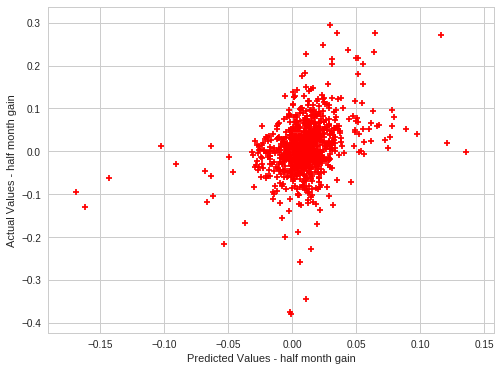

MSE: 0.00367608888119


In [56]:
# Note the difference in argument order
# optionally, you can chain "fit()" to the model object
model = sm.OLS(y, X)
model = model.fit()
predictions = model.predict(X)

# Plot the model
plt.figure(figsize=(8,6))
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values - half month gain")
plt.ylabel("Actual Values - half month gain")
plt.show()

print "MSE:", mean_squared_error(y, predictions)

In [57]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        half month gain   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     3.610
Date:                Fri, 23 Jun 2017   Prob (F-statistic):           1.50e-10
Time:                        10:42:12   Log-Likelihood:                 1267.8
No. Observations:                 916   AIC:                            -2470.
Df Residuals:                     883   BIC:                            -2310.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
adj_close             -0.0155      0.037     -0.422      0.673      -0.088       0.057
adj_high              -0.0019      0.041     -0.045      0.964      -0.083       0.079
adj_low               -0.0196      0.029     -0.666      0.505      -0.077       0.038
adj_open               0.0369      0.030      1.221      0.222      -0.022       0.096
adj_volume         -8.762e-09   1.99e-08     -0.441      0.660   -4.78e-08    3.03e-08
boll                   0.0010      0.001      0.752      0.452      -0.002       0.004
boll_lb                0.0013      0.001      0.986      0.325      -0.001       0.004
boll_ub                0.0007      0.001      0.519      0.604      -0.002       0.003
bollstatus             0.0015      0.012      0.129      0.898      -0.022       0.025
close                 -0.0060      0.027     -0.220      0.826      -0.059       0.047
close_12_ema           0.0014      0.002      0.715      0.475      -0.002       0.005
close_20_mstd         -0.0001   9.04e-05     -1.552      0.121      -0.000    3.71e-05
close_20_sma           0.0010      0.001      0.752      0.452      -0.002       0.004
close_26_ema          -0.0016      0.003     -0.543      0.587      -0.007       0.004
cr                 -9.857e-05   9.98e-05     -0.987      0.324      -0.000    9.74e-05
cr-ma1                 0.0001      0.000      0.669      0.504      -0.000       0.000
cr-ma2                 0.0001      0.000      0.564      0.573      -0.000       0.000
cr-ma3             -9.059e-05   9.81e-05     -0.923      0.356      -0.000       0.000
daily_change           0.0123      0.014      0.882      0.378      -0.015       0.040
dailyrate              0.0122      0.165      0.074      0.941      -0.312       0.337
derivative             0.0002      0.000      0.568      0.570      -0.000       0.001
ex-dividend            0.0994      0.156      0.638      0.523      -0.206       0.405
high                  -0.0028      0.039     -0.072      0.943      -0.079       0.073
low                    0.0232      0.027      0.848      0.397      -0.030       0.077
macd                   0.0030      0.003      1.161      0.246      -0.002       0.008
macdh                  0.0123      0.007      1.702      0.089      -0.002       0.027
macds                 -0.0031      0.001     -2.383      0.017      -0.006      -0.001
marketclose         8.451e-09   1.83e-08      0.461      0.645   -2.75e-08    4.44e-08
marketgain         -8.112e-09   1.83e-08     -0.442      0.658   -4.41e-08    2.79e-08
marketopen         -8.445e-09   1.83e-08     -0.461      0.645   -4.44e-08    2.75e-08
middle                 0.0048      0.007      0.646      0.519      -0.010       0.019
open                  -0.0182      0.020     -0.909      0.364      -0.058       0.021
open_-2_r              0.0029      0.0

In [ ]:
X = restaurants[['derivative']]
y = restaurants['half month gain']
reg_scores = cross_val_score(LinearRegression(), X, y, cv=4)
print reg_scores, np.mean(reg_scores)

In [ ]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i] > 0 and y_hat[i] > 0:
           TP += 1
    for i in range(len(y_hat)): 
        if y_hat[i] > 0 and y_actual[i] < 0:
           FP += 1
    for i in range(len(y_hat)): 
        if y_actual[i] < 0 and  y_hat[i] < 0:
           TN += 1
    for i in range(len(y_hat)): 
        if y_hat[i] < 0 and y_actual[i] > 0:
           FN += 1
    return(TP, FP, TN, FN)

In [ ]:
perf_measure(predictions, y)

In [ ]:
(464 + 115)*100/ (464+75+115+261)

In [ ]:
predictions.head()

In [ ]:
y.head()